In [1]:
import sys
from pathlib import Path

import gensim
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

CWD = Path('.').absolute()
sys.path.insert(0, str(CWD / 'python' / 'pysommy'))
sys.path.insert(0, str(CWD / 'python' / 'pysimple'))
from pysommy.sommy import BatchGenerator, Som, GaussianNeighbourhood, SomTrainer
from pysimple.io import from_tsv, to_tsv, write_lines, read_lines, dump_pickle, load_pickle

### Data

In [ ]:
DATA_DIR = CWD / 'data' / 'en'

In [ ]:
glove = gensim.models.KeyedVectors.load_word2vec_format(str(DATA_DIR / 'glove.6B.50d.w2v.txt'))

In [ ]:
profs = from_tsv(filepath=DATA_DIR / 'profs.tsv')
words = list(set(','.join(profs['name'] + ',' + profs['sim']).split(',')))
vectors = np.asarray([glove[word] for word in words])
vectors = vectors / (vectors * vectors).sum(axis=1)[:, np.newaxis] ** 0.5
write_lines(filepath=DATA_DIR / 'words2.txt', lines=words)
dump_pickle(filepath=DATA_DIR / 'vectors2.pickle', obj=vectors

### Model

In [2]:
DATA_DIR = CWD / 'data' / 'en'

In [3]:
words = list(read_lines(DATA_DIR / 'words2.txt'))
vectors = load_pickle(DATA_DIR / 'vectors2.pickle')
vectors.shape

(393, 50)

In [39]:
som = Som(height=128, width=128, depth=vectors.shape[1])
batch_gen = BatchGenerator(data=vectors, batch_size=8, shuffle=True)

In [40]:
max_epochs = 64
max_iters = len(batch_gen) * max_epochs
sigma_init = max(som.width, som.height) / 2
sigma_decay = lambda t: sigma_init * np.exp(- t * np.log(sigma_init) / max_iters)
lr_init = 0.1
lr_decay = lambda t: lr_init * np.exp(- t / max_iters)

In [ ]:
#iters = np.arange(max_iters)
#pd.Series(index=iters, data=map(lr_decay, iters)).plot(figsize=(10, 6), title='Learning rate')
#plt.show()
#pd.Series(index=iters, data=map(sigma_decay, iters)).plot(figsize=(10, 6), title='Sigma')
#plt.show()

In [41]:
gaussian = GaussianNeighbourhood(som=som, sigma_decay=sigma_decay)
trainer = SomTrainer(som=som, neighbourhood=gaussian, lr_decay=lr_decay)

In [42]:
trainer.fit(batch_gen=batch_gen, epochs=max_epochs, progress_bar=tqdm_notebook)

HBox(children=(IntProgress(value=0, max=64), HTML(value='')))

### Results

In [14]:
words = list(read_lines(DATA_DIR / 'words2.txt'))
vectors = load_pickle(DATA_DIR / 'vectors2.pickle')
profs = from_tsv(DATA_DIR / 'profs.tsv')
','.join(profs['name'])

'policeman,lawyer,secretary,salesperson,pharmacist,coiffeur,paramedic,caregiver,librarian,surveyor,chef,artist,labourer,teacher,actor,mechanic,pilot,machinist,physician,radiographer,surgeon,architect,broker,psychologist,engineer,chiropractor,nutritionist,electrician,landscaper,plumber,technologist,consultant,statistician,optician,dietitian,technician,accountant,hygienist,programmer,welder,musician,actuary,psychiatrist,midwife,butcher,veterinarian,firefighter,designer,judge,dentist'

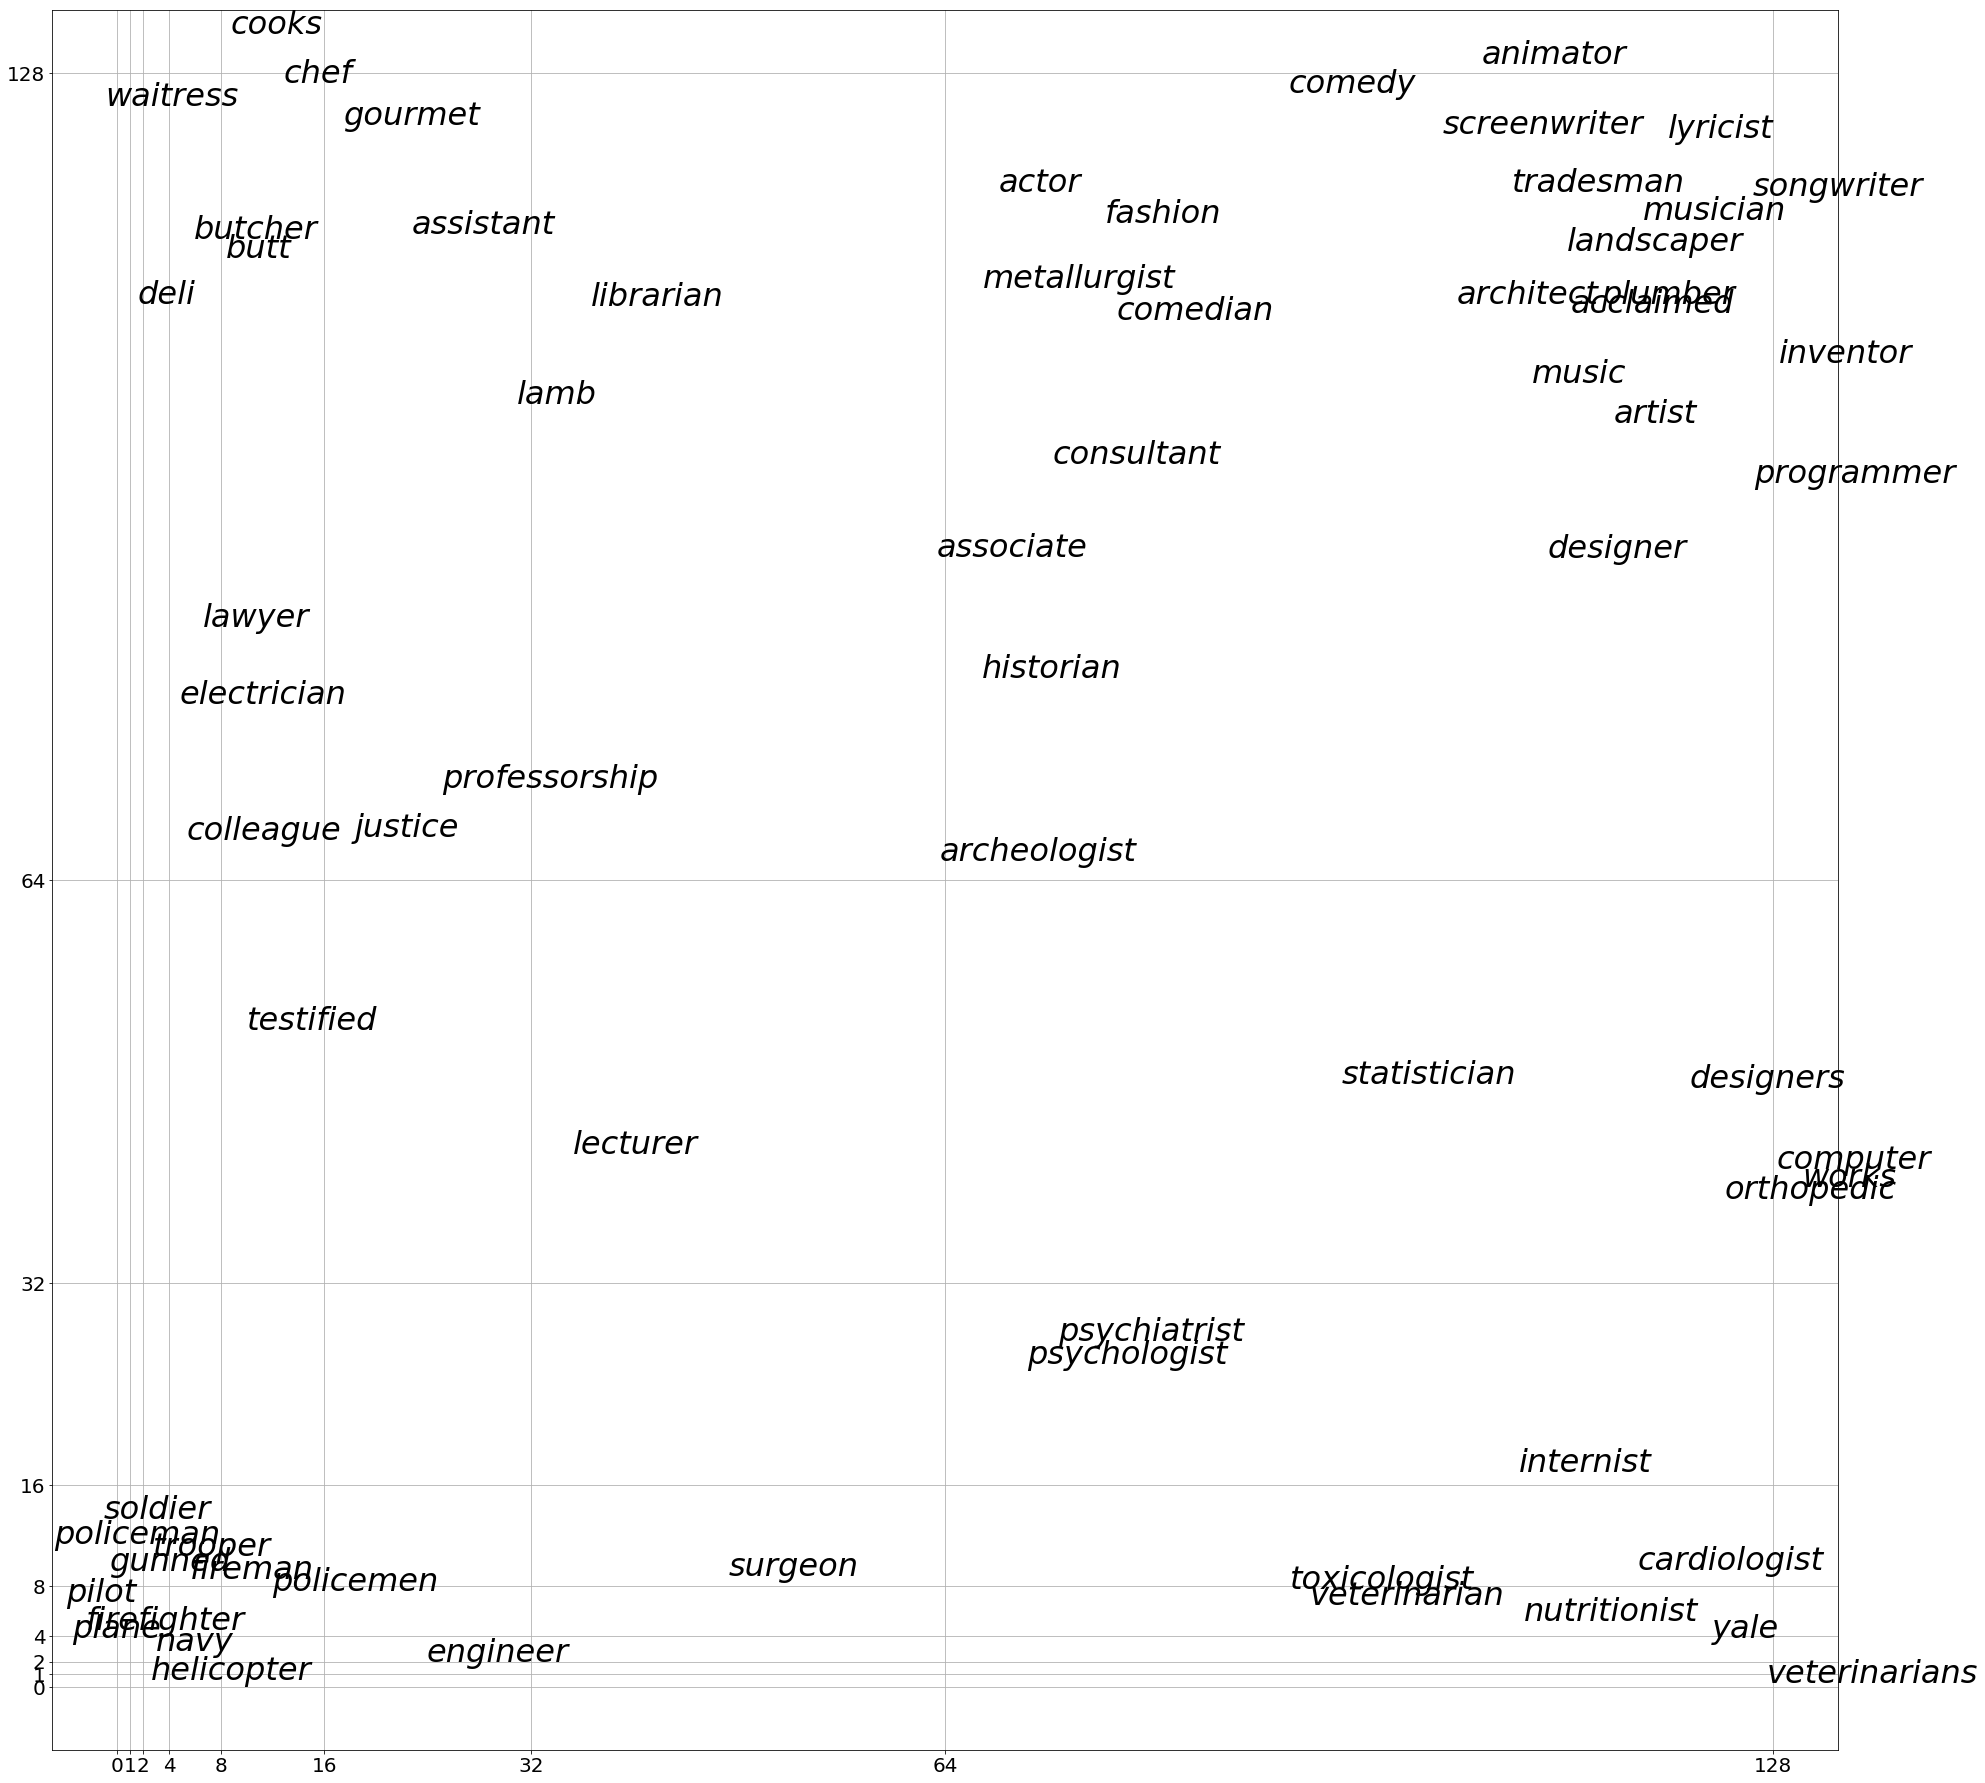

In [43]:
def get_ticks(max_val: int):
    ticks = [max_val]
    while ticks[-1] != 0:
        ticks.append(ticks[-1] // 2)
    return ticks

plt.figure(figsize=(32, 32))
plotted = []
names = """
policeman,lawyer,librarian,artist,chef,actor,surgeon,programmer,musician,veterinarian,architect,consultant,
butcher,firefighter,pilot,statistician,plumber,designer
""".replace('\n','').split(',')
for i, name in enumerate(names):
    prof = profs[profs['name'].eq(name)].iloc[0]
    for sim in [name] + prof['sim'].split(',')[:3]:
        if sim in plotted: continue
        plotted.append(sim)
        vec = vectors[words.index(sim)]
        x, y = som.closest(inp=vec[np.newaxis, :])[0]
        rx, ry = np.random.uniform(-1, 1, size=2) * 5
        #rx, ry = 0, 0
        plt.text(x + rx, y + ry, sim, size=32, style='italic', color='black')
plt.xticks(get_ticks(som.width), size=20)
plt.yticks(get_ticks(som.height), size=20)
plt.grid()
plt.xlim([-5, som.width + 5])
plt.ylim([-5, som.height + 5])
plt.show()
#plt.savefig('som.png')